# Step 1: Importing package
Calls yahoo finance API to download daily stock and index finances. If we do not have the yfinance package installed, we ca use the command line below to install it.

In [60]:
#!pip install yfinance
import yfinance as yf 

Next we will initialioze ticker class which enables us so download price history for a single symbol

In [61]:
sp500 = yf.Ticker("^GSPC")

In [62]:
#quey historical prices, query all data from beg when index was created
sp500 = sp500.history(period = "max")

In [64]:
#We can now check our dataset
#sp500

Here we have each row representing the price on a trading day. We will use this pandas df to predict whether the price will go up or down tomorrow

In [65]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-10-31 00:00:00-04:00', '2024-11-01 00:00:00-04:00',
               '2024-11-04 00:00:00-05:00', '2024-11-05 00:00:00-05:00',
               '2024-11-06 00:00:00-05:00', '2024-11-07 00:00:00-05:00',
               '2024-11-08 00:00:00-05:00', '2024-11-11 00:00:00-05:00',
               '2024-11-12 00:00:00-05:00', '2024-11-13 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24335, freq=None)

# Step 2: Cleaning our Data!
Before we create any machine models or analyze our data, it is always important to clean and visualize your data.

<Axes: xlabel='Date'>

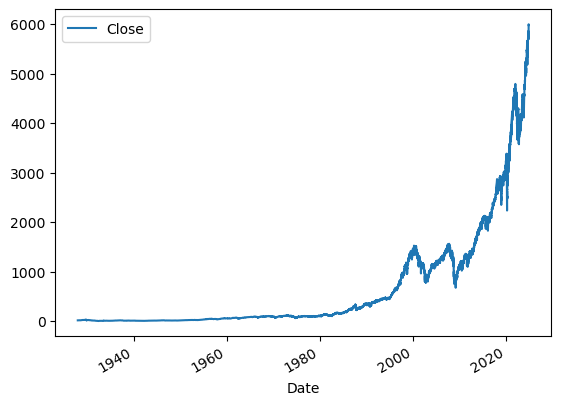

In [66]:
sp500.plot.line(y="Close", use_index = True)

Here, the x-axis represents our index, the trading days, dates and the y axis shows the closing prices. We can officially start our data cleaning by deletung some variables we dont need.

In [67]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [69]:
# Checking to see if they were deleted
#sp500

We can see that we checked to make sure we deleted our unnecessary columns. Our target for predicting is will the stock go up or down.Let us first start by creating a column titled "tomorrow". We can do this by making the "tomorrow" value equal to the Closing value

In [70]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
#sp500

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000
...,...,...,...,...,...,...
2024-11-07 00:00:00-05:00,5947.209961,5983.839844,5947.209961,5973.100098,4925740000,5995.540039
2024-11-08 00:00:00-05:00,5976.759766,6012.450195,5976.759766,5995.540039,4666740000,6001.350098
2024-11-11 00:00:00-05:00,6008.859863,6017.310059,5986.689941,6001.350098,4333000000,5983.990234


Now, we can create a "target" column which will be a boolean. 1 representing if the price went up, 0 is the price went down compared to todays price.

In [71]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
#sp500

Because in stock markets, using old data might not be helpful predictions because it shifts too much, so we are going toonly use a subset of our data. 

In [72]:
sp500 = sp500.loc["1990-1-01":].copy()
#sp500

# Step 3: Training Model

Now we can start creating our machine learning model! Before we do this, we need to initialize our model and split it

In [73]:
from sklearn.ensemble import RandomForestClassifier

#initializing model
# nestimators = # decision trees to train, higher = more accuracy
# min_sample_split = protects overfitting, higher = less likely to over fit but not ass accurate
# random_state = rerunning model gets same results
model = RandomForestClassifier(n_estimators = 150,min_samples_split= 150, random_state = 1)

One thing to note, because we are using time series data, if we use cross-validation, our traning predictions will look good, but our actual predictions on the test data will be horrible

In [74]:
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=150, n_estimators=150, random_state=1)

In [75]:
from sklearn.metrics import precision_score

# did our market go up when we predicted?
preds = model.predict(test[predictors])

#preds

Here because our predictions are in a numpy array, we can convert them to a pandas series

In [76]:
import pandas as pd
preds= pd.Series(preds, index = test.index)

In [33]:
precision_score(test["Target"], preds)

0.7777777777777778

A score of 77% accuracy is okay, but we can do it better

In [77]:
combined = pd.concat([test["Target"], preds], axis = 1)

<Axes: xlabel='Date'>

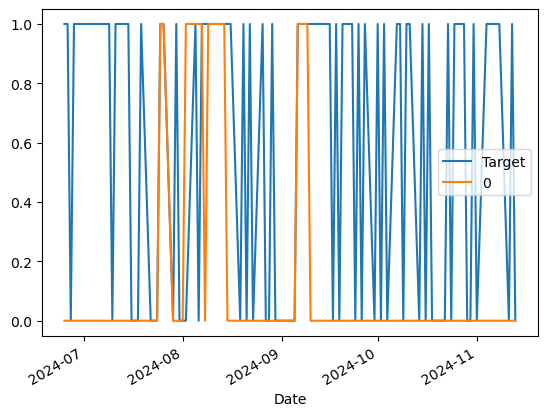

In [78]:
combined.plot()

Orange is predictions, blue is what happened. We predicted that the price would usually go down, but it mainly went up.

# Step 4: Building a Better Model

Now, lets remember our testing data only including those last 100 days. If we realisticaly want to predict, we want to be able to testn multiple years, testing larger situations which gives us more confidence over the years. So we can try backtesting

In [79]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [80]:
def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

Across all these 6k training rows, we were about 53% accurate. When we said the market would go up, it went up about 53% of those times

In [ ]:
predictions["Target"].value_counts()/predictions.shape[0]

Now, that we backtested, we have confidence in our model and know how we can improve our accuracy

# Step 5: Adding more Predictors

We can improve our model by adding in more predictors. Lets try it out!

Here, we can create a variety of rolling averages. We will calculate mean close price in 2, 5, 60, 250 and 1000 days. We will then find the closing ratio between todays closing price and that in those periods. 

In [53]:
horizons = [2, 5, 60, 250, 1000]
new_predictors=[]

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

#sp500

In [55]:
sp500 = sp500.dropna()

# Step 6 : Improving Model

Now that we added predictors to our sp500 ds, we can now improve our model to get better predictions

In [ ]:
model = RandomForestClassifier(n_estimators = 150,min_samples_split= 150, random_state = 1)

In [56]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    # returns prob that the stock price go up tomorrow
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [57]:
predictions = backtest(sp500, model, new_predictors)

In [58]:
predictions["Predictions"].value_counts()

Predictions
0.0    4730
1.0     553
Name: count, dtype: int64

In [59]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5895117540687161